# Spatial-IT RRMap OT Analysis

This notebook analyzes timepoint transitions in an `AnnData` object using the OT workflow in `rrmap_ot.py`.

## Objective
- Compute transitions between consecutive `course` labels.
- Compare source-to-destination `anno_L2` state flow.
- Review QC diagnostics (entropy + mass diagnostics for unbalanced OT).


In [9]:
from __future__ import annotations

from pathlib import Path
import os
import sys
import warnings

# Avoid cache issues in read-only/home-restricted environments
NOTEBOOK_TMP = Path.cwd().resolve() / "tmp"
os.environ.setdefault("MPLCONFIGDIR", str(NOTEBOOK_TMP / "matplotlib"))
os.environ.setdefault("NUMBA_CACHE_DIR", str(NOTEBOOK_TMP / "numba_cache"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)
Path(os.environ["NUMBA_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy as sc
from IPython.display import display

# Reproducibility
SEED = 0
np.random.seed(SEED)

# Resolve repo root even when Jupyter starts from a subdirectory
def find_project_root(start: Path, marker: str = "rrmap_ot.py") -> Path:
    for candidate in [start.resolve(), *start.resolve().parents]:
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(
        f"Could not find {marker} by walking up from {start.resolve()}."
    )

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import rrmap_ot

print(f"Notebook cwd: {Path.cwd().resolve()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Using rrmap_ot from: {Path(rrmap_ot.__file__).resolve()}")


Notebook cwd: /Users/christoffer/work/karolinska/development/spatial-OT/output/jupyter-notebook
Project root: /Users/christoffer/work/karolinska/development/spatial-OT
Using rrmap_ot from: /Users/christoffer/work/karolinska/development/spatial-OT/rrmap_ot.py


## Configuration

Set `ADATA_PATH` to your RRMap / Spatial-IT `.h5ad` file.

Defaults here use unbalanced centroid OT (recommended first pass for large datasets).


In [11]:
# ---- User configuration ----
ADATA_PATH = Path("/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad")

COURSE_KEY = "course"
STATE_KEY = "anno_L2"
EMBEDDING_KEY = None  # None => rrmap_ot fallback: X_scVI -> X_umap -> X_pca

# Run one model at a time to avoid cross-model transitions.
MODELS = {
    "Chronic": {
        "baseline": "MOG CFA",
        "courses": ["MOG CFA", "non symptomatic", "early onset", "chronic peak", "chronic long"],
    },
    "RR": {
        "baseline": "PLP CFA",
        "courses": [
            "PLP CFA", "onset I", "onset II", "monophasic",
            "peak I", "remitt I", "peak II", "remitt II", "peak III",
        ],
    },
}
MODEL_NAME = "RR"  # "Chronic", "RR", or None for full-dataset run
STRIP_COURSE_LABELS = True
COURSE_ORDER = None  # Used only when MODEL_NAME is None

METHOD = "unbalanced"  # "balanced" or "unbalanced"
MODE = "centroid"      # "centroid" (fast) or "cell" (heavy)
REG = 0.05
REG_M = 10.0
MAX_CELLS_PER_COURSE = 20_000
UNBALANCED_MASS_MODE = "normalized"  # "normalized" or "raw"
INCLUDE_ALL_STATES = False
RANDOM_STATE = 0

TOP_K = 3


In [12]:
# Load adata
if "adata" in globals() and hasattr(adata, "obs"):
    print("Using existing `adata` already present in notebook session.")
else:
    if not ADATA_PATH.exists():
        raise FileNotFoundError(
            f"ADATA_PATH does not exist: {ADATA_PATH}\n"
            "Set ADATA_PATH in the config cell to your .h5ad file."
        )
    adata = sc.read_h5ad(ADATA_PATH)

print(adata)


Using existing `adata` already present in notebook session.
AnnData object with n_obs × n_vars = 877141 × 5101
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'louvain_0.5', 'louvain_1', 'louvain_1.5', 'louvain_2', 'louvain_2.5', 'louvain_3', 'louvain_3.5', 'Cluster', 'Level1', 'Level2', 'Level3', 'Level3.1', 'grid_label', 'rbd_domain', 'rbd_domain_0.1', 'rbd_domain_0.2', 'rbd_domain_0.3', 'rbd_domain_0.5', 'rbd_domain_0.6', 'rbd_domain_0.7', 'rbd_domain_0.8', 'rbd_domain_0.9', 'rbd_domain_1.1', 'rbd_domain_1', 'rbd_domain_1.25', 'rbd_domain_1.4', 'rbd_domain_1.5', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'sample_name', 'course', 'condition', 'model', 'cytetype_annotation_louvain_3.5', 'cytetype_cellOntologyTerm_louvain_3.5', 'cluster_id', 'author_label', 'annotation', 'Class', 'state', 'CL_

In [13]:
# Basic validation and quick summary
required_obs = [COURSE_KEY, STATE_KEY]
missing_obs = [k for k in required_obs if k not in adata.obs]
if missing_obs:
    raise KeyError(f"Missing required obs keys: {missing_obs}")

print("Required obs keys present.")
print(f"Available embeddings in adata.obsm: {list(adata.obsm.keys())}")

print("\nCells per course (raw labels):")
display(adata.obs[COURSE_KEY].value_counts(dropna=False).rename("n_cells").to_frame())

if STRIP_COURSE_LABELS:
    course_raw = adata.obs[COURSE_KEY].astype("string")
    course_clean = course_raw.str.strip()
    n_changed = int((course_raw != course_clean).fillna(False).sum())
    if n_changed > 0:
        print(f"\nDetected {n_changed} cells with leading/trailing spaces in `{COURSE_KEY}` labels.")
        print("Cells per course (stripped labels):")
        display(course_clean.value_counts(dropna=False).rename("n_cells").to_frame())

print("\nCells per state (top 20):")
display(adata.obs[STATE_KEY].value_counts(dropna=False).head(20).rename("n_cells").to_frame())


Required obs keys present.
Available embeddings in adata.obsm: ['X_mana_gauss', 'X_mana_gauss_2neigh', 'X_pca', 'X_scVI', 'X_umap', 'spatial']

Cells per course (raw labels):


,n_cells
course,
peak III,108344
peak I,105761
monophasic,93898
chronic long,78239
remitt I,71522
peak II,70152
chronic peak,65703
PLP CFA,59168
early onset,58116



Cells per state (top 20):


,n_cells
anno_L2,
Oligodendrocyte,174835
Interneuron,130506
Microglia,103816
Astrocyte,102125
Endothelial,60810
Meningeal fibroblast,42899
Macrophage,42745
Neuron,39572
T cell,31211


## Compute OT Transitions

Runs `compute_ot_transitions(...)` from `rrmap_ot.py` and stores outputs in `adata.uns["ot_transitions"]`.


In [14]:
course_key_for_ot = COURSE_KEY
if STRIP_COURSE_LABELS:
    course_key_for_ot = f"{COURSE_KEY}__stripped"
    adata.obs[course_key_for_ot] = adata.obs[COURSE_KEY].astype("string").str.strip()

adata_for_ot = adata
course_order_for_ot = COURSE_ORDER

if MODEL_NAME is not None:
    if MODEL_NAME not in MODELS:
        raise KeyError(f"MODEL_NAME={MODEL_NAME!r} not found in MODELS: {list(MODELS.keys())}")

    model_cfg = MODELS[MODEL_NAME]
    model_courses = [str(c).strip() for c in model_cfg["courses"]]
    baseline = str(model_cfg.get("baseline", model_courses[0])).strip()
    if model_courses and baseline != model_courses[0]:
        warnings.warn(
            f"Model {MODEL_NAME!r} baseline {baseline!r} does not match first course {model_courses[0]!r}."
        )

    model_mask = adata.obs[course_key_for_ot].isin(model_courses).to_numpy()
    if int(model_mask.sum()) == 0:
        raise ValueError(
            f"No cells matched MODEL_NAME={MODEL_NAME!r} using course labels: {model_courses}"
        )

    adata_for_ot = adata[model_mask].copy()
    course_order_for_ot = model_courses

    present = set(adata_for_ot.obs[course_key_for_ot].dropna().unique().tolist())
    missing_courses = [c for c in model_courses if c not in present]
    if missing_courses:
        warnings.warn(
            f"Some configured courses are missing for MODEL_NAME={MODEL_NAME!r}: {missing_courses}"
        )

    print(f"Running model: {MODEL_NAME}")
    print(f"Course order: {course_order_for_ot}")
    print(f"Cells in model subset: {adata_for_ot.n_obs:,}")
else:
    print("Running full dataset (MODEL_NAME=None).")
    if course_order_for_ot is not None:
        print(f"Using explicit COURSE_ORDER with {len(course_order_for_ot)} labels.")

transitions, plans = rrmap_ot.compute_ot_transitions(
    adata=adata_for_ot,
    course_key=course_key_for_ot,
    state_key=STATE_KEY,
    embedding_key=EMBEDDING_KEY,
    method=METHOD,
    mode=MODE,
    course_order=course_order_for_ot,
    reg=REG,
    reg_m=REG_M,
    max_cells_per_course=MAX_CELLS_PER_COURSE,
    random_state=RANDOM_STATE,
    return_plans=True,
    include_all_states=INCLUDE_ALL_STATES,
    unbalanced_mass_mode=UNBALANCED_MASS_MODE,
)

print(f"Computed {len(transitions)} course-pair transition matrix/matrices.")
print("Pairs:", list(transitions.keys()))


Running model: RR
Course order: ['PLP CFA', 'onset I', 'onset II', 'monophasic', 'peak I', 'remitt I', 'peak II', 'remitt II', 'peak III']
Cells in model subset: 608,429
Computed 8 course-pair transition matrix/matrices.
Pairs: [('PLP CFA', 'onset I'), ('onset I', 'onset II'), ('onset II', 'monophasic'), ('monophasic', 'peak I'), ('peak I', 'remitt I'), ('remitt I', 'peak II'), ('peak II', 'remitt II'), ('remitt II', 'peak III')]


In [15]:
# Inspect top-k destinations per source state for each course pair
all_top_tables = {}

for pair, t_df in transitions.items():
    top = rrmap_ot.top_k_destinations(t_df, k=TOP_K, normalize_rows=True)

    rows = []
    for src_state, dsts in top.items():
        for rank, (dst_state, score) in enumerate(dsts, start=1):
            rows.append(
                {
                    "pair": f"{pair[0]}->{pair[1]}",
                    "source_state": src_state,
                    "rank": rank,
                    "dest_state": dst_state,
                    "score": score,
                }
            )

    top_df = pd.DataFrame(rows)
    all_top_tables[pair] = top_df

    print(f"\nTop transitions for {pair[0]} -> {pair[1]}")
    if top_df.empty:
        print("No positive mass transitions.")
    else:
        display(top_df.sort_values(["source_state", "rank"]).head(30))



Top transitions for PLP CFA -> onset I


,pair,source_state,rank,dest_state,score
0,PLP CFA->onset I,Arachnoid barrier,1,Arachnoid barrier,0.491970
1,PLP CFA->onset I,Arachnoid barrier,2,Monocyte-derived,0.366718
2,PLP CFA->onset I,Arachnoid barrier,3,Meningeal fibroblast,0.120463
3,PLP CFA->onset I,Artifact,1,Artifact,0.916253
4,PLP CFA->onset I,Artifact,2,Macrophage,0.046461
5,PLP CFA->onset I,Artifact,3,T cell,0.020950
6,PLP CFA->onset I,Astrocyte,1,Astrocyte,0.999037
7,PLP CFA->onset I,Astrocyte,2,Microglia,0.000842
8,PLP CFA->onset I,Astrocyte,3,Artifact,0.000080
9,PLP CFA->onset I,B cell,1,B cell,0.810858



Top transitions for onset I -> onset II


,pair,source_state,rank,dest_state,score
0,onset I->onset II,Arachnoid barrier,1,Arachnoid barrier,7.823384e-01
1,onset I->onset II,Arachnoid barrier,2,Monocyte-derived,8.173710e-02
2,onset I->onset II,Arachnoid barrier,3,Meningeal fibroblast,7.782010e-02
3,onset I->onset II,Artifact,1,Artifact,7.060779e-01
4,onset I->onset II,Artifact,2,Schwann cell,1.510214e-01
5,onset I->onset II,Artifact,3,T cell,6.112270e-02
6,onset I->onset II,Astrocyte,1,Astrocyte,9.726758e-01
7,onset I->onset II,Astrocyte,2,Microglia,2.202803e-02
8,onset I->onset II,Astrocyte,3,Endothelial,1.261748e-03
9,onset I->onset II,B cell,1,B cell,9.999978e-01



Top transitions for onset II -> monophasic


,pair,source_state,rank,dest_state,score
0,onset II->monophasic,Arachnoid barrier,1,Arachnoid barrier,9.999159e-01
1,onset II->monophasic,Arachnoid barrier,2,Meningeal fibroblast,8.122032e-05
2,onset II->monophasic,Arachnoid barrier,3,BAM,2.760795e-06
3,onset II->monophasic,Artifact,1,Artifact,8.454627e-01
4,onset II->monophasic,Artifact,2,Meningeal fibroblast,6.884331e-02
5,onset II->monophasic,Artifact,3,Macrophage,3.105178e-02
6,onset II->monophasic,Astrocyte,1,Astrocyte,9.994703e-01
7,onset II->monophasic,Astrocyte,2,Microglia,4.578319e-04
8,onset II->monophasic,Astrocyte,3,Meningeal fibroblast,2.695817e-05
9,onset II->monophasic,B cell,1,B cell,9.999996e-01



Top transitions for monophasic -> peak I


,pair,source_state,rank,dest_state,score
0,monophasic->peak I,Arachnoid barrier,1,Arachnoid barrier,6.272523e-01
1,monophasic->peak I,Arachnoid barrier,2,Meningeal fibroblast,1.053593e-01
2,monophasic->peak I,Arachnoid barrier,3,Macrophage,9.551584e-02
3,monophasic->peak I,Artifact,1,Artifact,7.182627e-01
4,monophasic->peak I,Artifact,2,Macrophage,1.643159e-01
5,monophasic->peak I,Artifact,3,T cell,8.090467e-02
6,monophasic->peak I,Astrocyte,1,Astrocyte,7.903044e-01
7,monophasic->peak I,Astrocyte,2,Microglia,1.403975e-01
8,monophasic->peak I,Astrocyte,3,T cell,3.216855e-02
9,monophasic->peak I,B cell,1,B cell,9.999856e-01



Top transitions for peak I -> remitt I


,pair,source_state,rank,dest_state,score
0,peak I->remitt I,Arachnoid barrier,1,Arachnoid barrier,9.999992e-01
1,peak I->remitt I,Arachnoid barrier,2,Meningeal fibroblast,7.741027e-07
2,peak I->remitt I,Arachnoid barrier,3,Schwann cell,3.112034e-09
3,peak I->remitt I,Artifact,1,Artifact,8.366034e-01
4,peak I->remitt I,Artifact,2,Oligodendrocyte,6.675924e-02
5,peak I->remitt I,Artifact,3,Schwann cell,4.912252e-02
6,peak I->remitt I,Astrocyte,1,Astrocyte,9.994833e-01
7,peak I->remitt I,Astrocyte,2,Oligodendrocyte,4.865582e-04
8,peak I->remitt I,Astrocyte,3,Interneuron,1.356245e-05
9,peak I->remitt I,B cell,1,B cell,9.999998e-01



Top transitions for remitt I -> peak II


,pair,source_state,rank,dest_state,score
0,remitt I->peak II,Arachnoid barrier,1,Arachnoid barrier,7.943832e-01
1,remitt I->peak II,Arachnoid barrier,2,Meningeal fibroblast,2.055727e-01
2,remitt I->peak II,Arachnoid barrier,3,Macrophage,2.617331e-05
3,remitt I->peak II,Artifact,1,Artifact,5.788974e-01
4,remitt I->peak II,Artifact,2,Macrophage,4.139818e-01
5,remitt I->peak II,Artifact,3,Meningeal fibroblast,5.860379e-03
6,remitt I->peak II,Astrocyte,1,Astrocyte,9.986910e-01
7,remitt I->peak II,Astrocyte,2,Microglia,5.219629e-04
8,remitt I->peak II,Astrocyte,3,Artifact,4.269881e-04
9,remitt I->peak II,B cell,1,B cell,7.368064e-01



Top transitions for peak II -> remitt II


,pair,source_state,rank,dest_state,score
0,peak II->remitt II,Arachnoid barrier,1,Arachnoid barrier,9.999998e-01
1,peak II->remitt II,Arachnoid barrier,2,Meningeal fibroblast,1.831784e-07
2,peak II->remitt II,Arachnoid barrier,3,Interneuron,1.659202e-10
3,peak II->remitt II,Artifact,1,Interneuron,3.225071e-01
4,peak II->remitt II,Artifact,2,Artifact,2.408783e-01
5,peak II->remitt II,Artifact,3,Oligodendrocyte,2.191721e-01
6,peak II->remitt II,Astrocyte,1,Astrocyte,9.987943e-01
7,peak II->remitt II,Astrocyte,2,Oligodendrocyte,6.953319e-04
8,peak II->remitt II,Astrocyte,3,Interneuron,3.361071e-04
9,peak II->remitt II,B cell,1,Meningeal fibroblast,3.750091e-01



Top transitions for remitt II -> peak III


,pair,source_state,rank,dest_state,score
0,remitt II->peak III,Arachnoid barrier,1,Arachnoid barrier,2.799786e-01
1,remitt II->peak III,Arachnoid barrier,2,Macrophage,2.141536e-01
2,remitt II->peak III,Arachnoid barrier,3,Meningeal fibroblast,2.029537e-01
3,remitt II->peak III,Artifact,1,Artifact,7.875854e-01
4,remitt II->peak III,Artifact,2,Macrophage,1.275259e-01
5,remitt II->peak III,Artifact,3,Microglia,3.069811e-02
6,remitt II->peak III,Astrocyte,1,Astrocyte,8.204483e-01
7,remitt II->peak III,Astrocyte,2,Microglia,1.501390e-01
8,remitt II->peak III,Astrocyte,3,T cell,1.299433e-02
9,remitt II->peak III,B cell,1,B cell,9.999971e-01


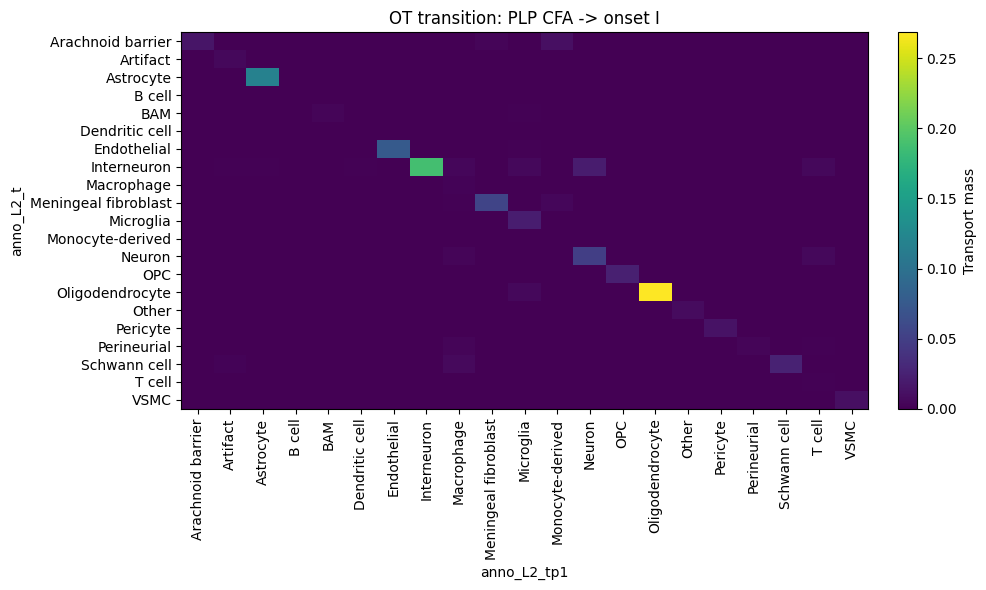

In [16]:
# Plot one heatmap
if not transitions:
    raise ValueError("No transitions were computed. Check course ordering and required keys.")

pair_to_plot = next(iter(transitions.keys()))
t_plot = transitions[pair_to_plot]

ax = rrmap_ot.plot_transition_heatmap(
    t_plot,
    title=f"OT transition: {pair_to_plot[0]} -> {pair_to_plot[1]}",
    figsize=(10, 6),
    cmap="viridis",
)
plt.tight_layout()
plt.show()


In [17]:
# QC: outgoing entropy + unbalanced mass diagnostics for one pair
pair_qc = next(iter(transitions.keys()))
t_qc = transitions[pair_qc]

entropy = rrmap_ot.outgoing_entropy(t_qc).sort_values(ascending=False)
print(f"Outgoing entropy ({pair_qc[0]} -> {pair_qc[1]})")
display(entropy.to_frame().head(30))

if METHOD == "unbalanced":
    payload = plans[pair_qc]
    source_labels = payload.get("source_labels")
    target_labels = payload.get("target_labels")

    diag = rrmap_ot.unbalanced_mass_diagnostics(
        plan=payload["plan"],
        a=payload["a"],
        b=payload["b"],
        source_labels=source_labels,
        target_labels=target_labels,
    )

    print("Unbalanced mass summary:")
    display(pd.Series(diag["summary"], name="value").to_frame())

    print("Source mass diagnostics (head):")
    display(diag["source"].head(20))

    print("Target mass diagnostics (head):")
    display(diag["target"].head(20))


Outgoing entropy (PLP CFA -> onset I)


,outgoing_entropy
anno_L2_t,
Perineurial,2.479743e+00
Arachnoid barrier,1.549385e+00
BAM,1.259230e+00
Schwann cell,1.255375e+00
Interneuron,1.101541e+00
Neuron,1.095109e+00
B cell,8.895907e-01
Meningeal fibroblast,6.924904e-01
Artifact,5.593887e-01


Unbalanced mass summary:


,value
total_a,1.000000
total_b,1.000000
transported_mass,0.987839
source_l1_deviation,0.015583
target_l1_deviation,0.015586


Source mass diagnostics (head):


,a,row_sum,difference,ratio
source,,,,
Arachnoid barrier,0.031199,0.030335,-8.638290e-04,0.972313
Artifact,0.006439,0.006420,-1.959955e-05,0.996956
Astrocyte,0.115468,0.116151,6.830226e-04,1.005915
B cell,0.000321,0.000316,-4.961315e-06,0.984550
BAM,0.005206,0.005100,-1.051406e-04,0.979802
Dendritic cell,0.000152,0.000152,-4.393116e-07,0.997112
Endothelial,0.078928,0.077815,-1.112578e-03,0.985904
Interneuron,0.230969,0.228471,-2.498465e-03,0.989183
Macrophage,0.002383,0.002411,2.844363e-05,1.011936


Target mass diagnostics (head):


,b,col_sum,difference,ratio
target,,,,
Arachnoid barrier,0.015046,0.014941,-0.000105,0.993050
Artifact,0.012215,0.011920,-0.000294,0.975890
Astrocyte,0.122334,0.119243,-0.003091,0.974730
B cell,0.000270,0.000258,-0.000012,0.956790
BAM,0.003317,0.003265,-0.000052,0.984322
Dendritic cell,0.004125,0.003772,-0.000354,0.914263
Endothelial,0.075121,0.074748,-0.000372,0.995045
Interneuron,0.186292,0.186500,0.000209,1.001121
Macrophage,0.025319,0.023958,-0.001361,0.946236


In [18]:
# Optional: save transition matrices and top tables for downstream review
run_label = (MODEL_NAME if MODEL_NAME is not None else "full_dataset").replace(" ", "_")
out_dir = PROJECT_ROOT / "output" / "ot_transition_tables" / run_label
out_dir.mkdir(parents=True, exist_ok=True)

for pair, t_df in transitions.items():
    pair_str = f"{pair[0]}__to__{pair[1]}".replace("/", "-")
    t_df.to_csv(out_dir / f"transition_{pair_str}.csv")

for pair, top_df in all_top_tables.items():
    pair_str = f"{pair[0]}__to__{pair[1]}".replace("/", "-")
    top_df.to_csv(out_dir / f"topk_{pair_str}.csv", index=False)

print(f"Saved tables to: {out_dir}")


Saved tables to: /Users/christoffer/work/karolinska/development/spatial-OT/output/ot_transition_tables/RR


In [ ]:
# Optional heavy run (cell mode): uncomment when needed
# transitions_cell = rrmap_ot.compute_ot_transitions(
#     adata=adata,
#     course_key=COURSE_KEY,
#     state_key=STATE_KEY,
#     embedding_key=EMBEDDING_KEY,
#     method=METHOD,
#     mode="cell",
#     course_order=COURSE_ORDER,
#     reg=REG,
#     reg_m=REG_M,
#     max_cells_per_course=5_000,
#     random_state=RANDOM_STATE,
#     include_all_states=INCLUDE_ALL_STATES,
#     unbalanced_mass_mode=UNBALANCED_MASS_MODE,
# )
# print("Cell-mode pairs:", list(transitions_cell.keys()))


# Optimal Transport Transitions Across RRMap Timepoints  
## Lesion Ecology Interpretation (Balo / Relapsing Context)

This document summarizes biologically interpretable transition patterns derived from Optimal Transport (OT) analysis across disease courses:

- Monophasic → Peak I  
- Peak I → Remission I  
- Remission I → Peak II  
- Peak II → Remission II  
- Remission II → Peak III  

The goal is to distinguish:

- True biological transitions  
- Spatial niche adjacency  
- Structural stability  
- Segmentation / artifact effects  

---

# 1️⃣ Global structural pattern

## Stable anatomical scaffolds

These compartments predominantly self-transition:

- Arachnoid barrier → Arachnoid barrier  
- Meningeal fibroblast → Meningeal fibroblast  
- Endothelial → Endothelial  
- Astrocyte → Astrocyte  
- Neurons → Neurons  

**Interpretation**

These represent **tissue architecture**, not transient inflammatory states.

They serve as the structural framework within which lesion dynamics occur.

---

# 2️⃣ Myeloid dynamics (primary biological signal)

## Monophasic → Peak I

Key flows:

- BAM → Macrophage (~0.60)  
- BAM → Microglia (~0.10)  

**Interpretation**

Border-associated macrophages (BAMs) contribute to early lesion macrophage pools.  
This reflects initial immune infiltration and activation.

---

## Peak I → Remission I

Key flows:

- Macrophage → Macrophage (~0.37)  
- Macrophage → Microglia (~0.15)  
- Macrophage → Interneuron (~0.17) ⚠️  

**Interpretation**

- Partial inflammatory resolution  
- Redistribution toward resident microglial states  
- Immune → neuron transitions likely reflect **spatial adjacency**, not lineage

---

## Remission I → Peak II

Key flow:

- Macrophage → Macrophage (~0.99)

**Interpretation**

Relapse reactivation of inflammatory macrophages.  
Self-amplifying lesion macrophage expansion.

---

## Peak II → Remission II

Key flows:

- Macrophage → Interneuron (~0.30) ⚠️  
- Macrophage → Schwann cell (~0.20) ⚠️  
- Macrophage → Meningeal fibroblast (~0.17) ⚠️  

**Interpretation**

Not lineage transitions.

Reflects immune withdrawal and redistribution toward structural niches.

---

## Remission II → Peak III

Key flows:

- Macrophage → Macrophage (~0.56)  
- Macrophage → Microglia (~0.39)

**Interpretation**

Reactivation of inflammatory myeloid ecology at relapse.

---

# 3️⃣ Barrier and meningeal remodeling

## Arachnoid barrier transitions

Observed flows:

- Arachnoid barrier → Fibroblast  
- Arachnoid barrier → Macrophage (later peaks)

**Interpretation**

Barrier remodeling and immune infiltration at meningeal interfaces.

---

## Fibroblast dynamics

Example:

Peak II → Remission II:

- Fibroblast → Arachnoid barrier (~0.31)

**Interpretation**

Reversible barrier restructuring during remission.

---

# 4️⃣ Lymphoid compartments

Highly stable:

- B cell → B cell ~1.0  
- Dendritic cell → Dendritic cell ~1.0  

Exception:

Peak II → Remission II:

- B cell → Fibroblast (~0.37) ⚠️  

Likely niche adjacency, not fate conversion.

---

# 5️⃣ Vascular–immune coupling

Example:

Remission II → Peak III:

- Endothelial → Microglia (~0.07)  
- Endothelial → T cell (~0.07)

**Interpretation**

Heightened vessel–immune interaction during relapse.

---

# 6️⃣ Neuronal compartments

Predominantly self-stable:

- Interneuron → Interneuron ~0.99  

But relapse adjacency appears:

- Interneuron → Macrophage  
- Interneuron → Microglia  

Reflects inflammatory proximity to neuronal niches.

---

# 7️⃣ Artifact compartment behavior

Examples:

- Artifact → Macrophage  
- Artifact → Oligodendrocyte  
- Artifact → Interneuron  

**Interpretation**

Represents:

- Segmentation bleed  
- Ambient RNA  
- Structural transcript spray  

Useful for leakage diagnostics.

---

# 8️⃣ Integrated lesion ecology model

## Monophasic → Peak I
- BAMs seed inflammatory macrophages  
- Barrier compartments stable  
- Early immune recruitment  

## Peak I → Remission I
- Partial macrophage resolution  
- Structural niches dominate  

## Remission I → Peak II
- Macrophage reactivation  
- Lesion inflammation returns  

## Peak II → Remission II
- Immune redistribution  
- Barrier remodeling  
- Structural restoration  

## Remission II → Peak III
- Myeloid re-expansion  
- Vessel–immune coupling  
- Relapse reboot  

---

# 9️⃣ Biological vs adjacency transitions

## Likely true biological transitions

- BAM → Macrophage  
- Macrophage ↔ Microglia  
- Fibroblast ↔ Barrier  
- Vessel ↔ Immune coupling  

## Likely spatial adjacency artifacts

- Macrophage → Neuron  
- Dendritic → Neuron  
- B cell → Fibroblast  
- Artifact → Multiple states  

---

# 🔟 Interpretation summary

Optimal Transport reveals:

- Stable anatomical scaffolds  
- Cyclic inflammatory myeloid expansion  
- Barrier remodeling across relapses  
- Immune redistribution during remission  
- Spatial adjacency driving cross-lineage flows  

---

# One-line conclusion

**Relapsing lesion ecology is driven by cyclic myeloid activation layered on a stable structural scaffold, with barrier and vascular interfaces acting as dynamic immune gateways.**

## Next Steps
- Compare `METHOD="balanced"` vs `METHOD="unbalanced"` and inspect how entropy changes.
- Provide an explicit `COURSE_ORDER` if lexical sorting does not match biological time.
- If centroid mode is too coarse, run cell mode on selected course pairs with lower `max_cells_per_course`.
